# pyfox example


In [1]:
# This cell makes html renders of the notebook have hidden code cells.
# Especially useful for presentations. It does nothing within the
# jupyter lab environment.
from IPython.display import HTML

hide_me = ''
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()">
<input type="submit" id="toggleButton" value="Show Code">
</form>''')

In [2]:
# netcdf/numpy/xray/stats
import numpy as np
import xarray as xr
import yaml

# OS interaction
import os

# import plotting
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import string
import datetime
import pandas as pd
import copy
import btmm_process

# Often there are annoying "divide by zero" warning messages. They are not useful so we ignore them.
import warnings
warnings.filterwarnings("ignore")

## Format plots

In [3]:
%matplotlib inline
# Higher resolution figures within the notebook
# %config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi']= 100

# Set the plot style from the seaborn library
sns.set_style("whitegrid")
context = 'paper'
sns.set_context("paper", rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

# Define a default color palette (this should be fairly color blind friendly)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(sns.color_palette(flatui))

# Define a line style list
ls_list = ['-', '--', ':', '-']
ms_list = ['v', '*', 's', 'o']

alphabet = list(string.ascii_lowercase)

### Directories

- The example notebook assumes that the directory structure is identical to the one found on github.

In [4]:
# DTS data
dir_dts_data = os.getcwd()
dir_data_cal = os.path.join(dir_dts_data, 'calibrated')
dir_data_raw = os.path.join(dir_dts_data,  'raw_netcdf')
dir_data_final = os.path.join(dir_dts_data, 'final')

# Met data
dir_ref_data = os.path.join(dir_dts_data, 'reference_temperature')

#### Load the configuration file

We need to refer to the location library later for mapping the reference sections and evaluating the calibration.

In [5]:
os.chdir(dir_dts_data)

# Read location library
cfg = os.path.join(dir_dts_data, 'example_configuration.yml')
cfg = yaml.load(cfg)
with open(cfg, 'r') as stream:
    cfg = yaml.load(stream)

# For ease of reference the location library is stored in its own dictionary.
phys_locs = cfg['location_library']
# Extract out the reference baths from the mapping library.
#Reference baths MUST be labeled with `calibration` as the `loc_type`.
bath_names = [pl for pl in phys_locs
              if phys_locs[pl]['loc_type'] == 'calibration']

# Finalized dataset

This step can be run after calibrating the FODS data, e.g. within the config file

```python
final_flag = True
```

### Data check - file contents

First, let us see what is in the final datasets. Each "location type" is now its own netcdf.

In [7]:
os.chdir(dir_data_final)
heat = xr.open_dataset('example_final_channel 1_20190722-0000_heated.nc')
unheat = xr.open_dataset('example_final_channel 1_20190722-0000_unheated.nc')
print(heat)
print(unheat)

<xarray.Dataset>
Dimensions:   (core: 2, time: 60, xyz: 1630)
Coordinates:
  * xyz       (xyz) int64 0 1 2 3 4 5 6 7 ... 1623 1624 1625 1626 1627 1628 1629
  * time      (time) datetime64[ns] 2019-07-22T00:00:05 ... 2019-07-22T00:05:00
  * core      (core) object 'p1' 'p2'
    x         (core, xyz) float64 ...
    y         (core, xyz) float64 ...
    z         (core, xyz) float64 ...
Data variables:
    cal_temp  (core, time, xyz) float64 ...
Attributes:
    dt:       5s
    dLAF:     0.254
<xarray.Dataset>
Dimensions:   (core: 2, time: 60, xyz: 1630)
Coordinates:
  * xyz       (xyz) int64 0 1 2 3 4 5 6 7 ... 1623 1624 1625 1626 1627 1628 1629
  * time      (time) datetime64[ns] 2019-07-22T00:00:05 ... 2019-07-22T00:05:00
  * core      (core) object 'p1' 'p2'
    x         (core, xyz) float64 ...
    y         (core, xyz) float64 ...
    z         (core, xyz) float64 ...
Data variables:
    cal_temp  (core, time, xyz) float64 ...
Attributes:
    dt:       5s
    dLAF:     0.254


The netcdf still contains the stokes and anti-stokes intensities (`Ps` and `Pas`) and the instrument reported temperature (now renamed to `instr_temp`). Additionally, other data variables have been included: $log(\frac{P_s}{P_{as}})$, the calibrated temperature (`cal_temp`), and the temperatures within the reference sections (`coldProbe` and `warmProbe`). All variables are matrices with dimensions labeled by length along fiber (`LAF`) and time (`time`), except the reference temperatures which are just labeled by time. 

We have now added several coordinates that label locations along the fiber. These locations allow us to know that, for instance, LAFs between 505.0m and 564.0m belong to the fiber in the southeast corner of the grassfield. We can see that below. This labeling is how we convert from LAF to a physical coordinate for the data.

### Map the data


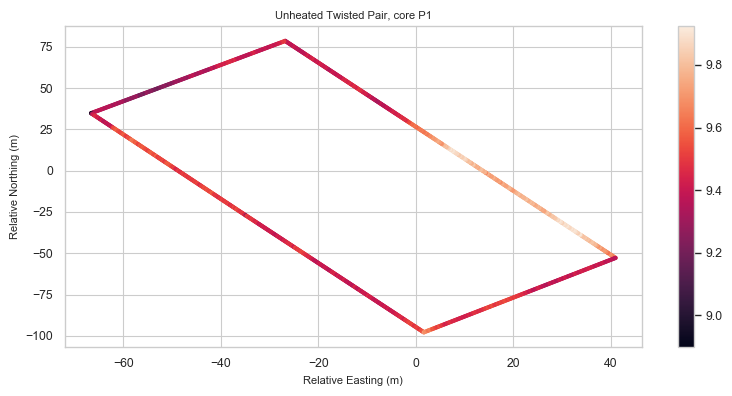

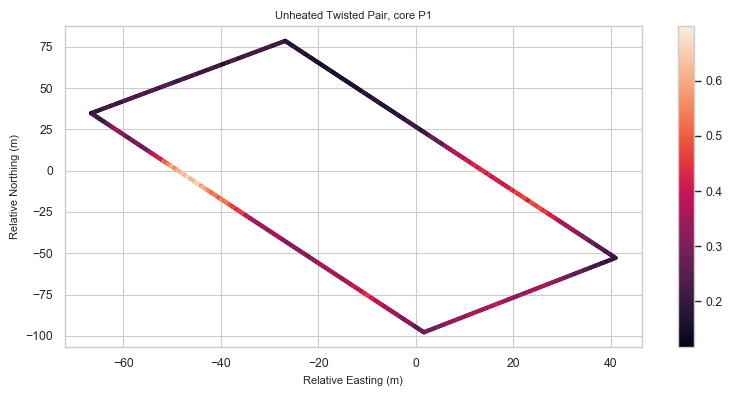

In [17]:
# Time average the data
smpl_data_mean = unheat.sel(core='p1').mean(dim='time')

# Mean
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_title('Unheated Twisted Pair, core P1')

# The calibrated temperature data
im = ax.scatter(smpl_data_mean.x, smpl_data_mean.y, 5, smpl_data_mean.cal_temp)

ax.autoscale(enable=True)
ax.set_ylabel('Relative Northing (m)')
ax.set_xlabel('Relative Easting (m)')

fig.colorbar(im)
fig.tight_layout()

# Time average the data
smpl_data_std = unheat.sel(core='p1').std(dim='time')

# Mean
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_title('Unheated Twisted Pair, core P1')

# The calibrated temperature data
im = ax.scatter(smpl_data_std.x, smpl_data_std.y, 5, smpl_data_std.cal_temp)

ax.autoscale(enable=True)
ax.set_ylabel('Relative Northing (m)')
ax.set_xlabel('Relative Easting (m)')

fig.colorbar(im)
fig.tight_layout()

Figure description

Text(0.5, 0, 'Relative height from center point (m)')

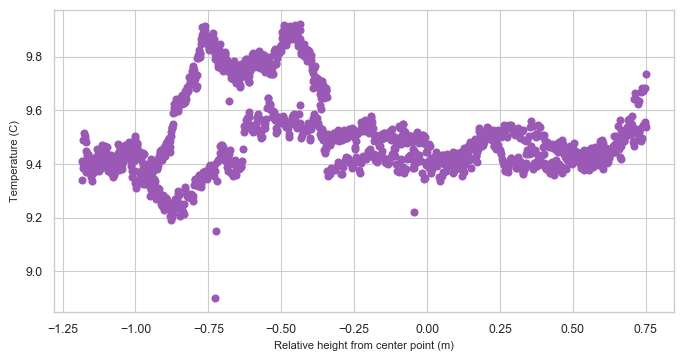

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(smpl_data_mean.z, smpl_data_mean.cal_temp, 'o')
ax.set_ylabel('Temperature (C)')
ax.set_xlabel('Relative height from center point (m)')

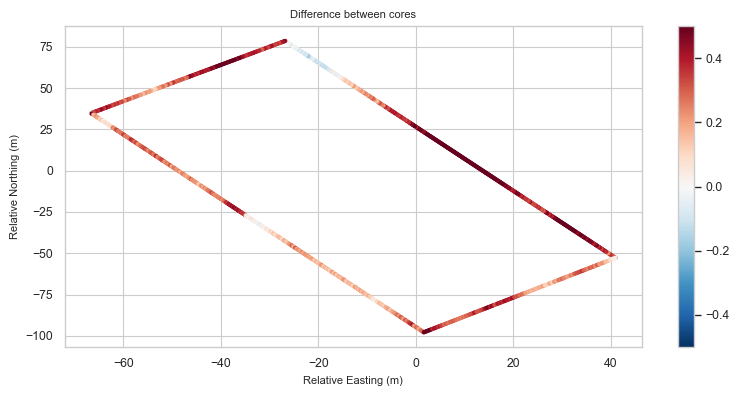

In [25]:
# Mean
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.set_title('Difference between cores')

# The calibrated temperature data
im = ax.scatter(smpl_data_mean.x, smpl_data_mean.y, 5,
                unheat.sel(core='p1').mean(dim='time').cal_temp
                - unheat.sel(core='p2').mean(dim='time').cal_temp,
                cmap=plt.get_cmap('RdBu_r'), vmin=-0.5, vmax=0.5)

ax.autoscale(enable=True)
ax.set_ylabel('Relative Northing (m)')
ax.set_xlabel('Relative Easting (m)')

fig.colorbar(im)
fig.tight_layout()